In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from copy import deepcopy
from scipy.integrate import quad as integrate

In [2]:
def Boys(T, m):
    """ boys function from their definition with numerical quadrature """
    def boys_int_func( t, T, m ):
        return t**(2*m) * np.exp(-T*t**2)
    ret, _ = integrate( boys_int_func, 0, 1, args=(T,m) )
    return ret


class Shell:
    def __init__(self, l_, np_, i_ ):
        self.l = l_
        self.np = np_
        self.i = i_
        self.R = np.zeros(shape = 3)
        self.z = np.zeros(shape = np_)
        self.k = np.zeros(shape = np_)
        
    def __repr__(self):
        ret =  " shell " + str(self.i) + " at " + str(self.R)  + "\n"
        ret += "      np: " + str(self.np) + "\n"
        ret += "      z: " + str(self.z) + "\n"
        ret += "      K: " + str(self.k) + "\n"
        return ret

def Knorm( z1,z2,R1,R2 ):
    """ Obara-Saika eq 47 """
    return np.sqrt(2.) * (np.pi)**(5/4) / (z1+z2) * np.exp( - z1*z2/(z1+z2)*np.sum((R1-R2)**2) )

class OSvectors:
    pass

def compute_V( a,b,G, c,d,N, H, ipa,ipb,ipc,ipd):
    """ computes an aux struct with a bunch of intermediates values 
        efficiency is not the key factor , here """
    A = a.R
    B = b.R + G
    C = c.R + H
    D = d.R + N + H

    za = a.z[ipa]
    zb = b.z[ipb]
    zc = c.z[ipc]
    zd = d.z[ipd]
    
    ka = a.k[ipa]
    kb = b.k[ipb]
    kc = c.k[ipc]
    kd = d.k[ipd]

    zp  = za+zb
    zq  = zc+zd
    z   = zp+zq
    rho = zp*zq/z

    aux = OSvectors()
    
    aux.zp1 = 1./(2.*zp)
    aux.zp2 = - rho/(2.*zp**2)
    aux.zq1 = 1./(2.*zq)
    aux.zq2 = - rho/(2.*zq**2)
    aux.inv_2z = 1. / 2. / z

    P = ( za*A + zb*B ) / zp
    Q = ( zc*C + zd*D ) / zq
    W = ( zp*P + zq*Q ) / z
    
    aux.PA = P - A
    aux.PB = P - B
    aux.QC = Q - C
    aux.QD = Q - D
    aux.WQ = W - Q
    aux.WP = W - P
    aux.PQ = P - Q
    rpq2 = np.sum(aux.PQ**2)
    aux.T  = rho * rpq2
    
    K  = ka*kb*kc*kd
    K1 = Knorm( za,zb,A,B )
    K2 = Knorm( zc,zd,C,D )
    aux.Kfac = K * K1 * K2 / np.sqrt(z)
    
    aux.gap = 2.*za
    aux.gbp = 2.*zb
    aux.gcp = 2.*zc
    aux.gdp = 2.*zd
    
    
#    print(T, A[0],B[0],C[0],D[0],P[0],Q[0],W, PA, WP , gp)
    
    return aux
    

def ssss_4c2e( a,b,G, c,d,N, H ):
    """ computes ssss """
    
    L = a.l + b.l + c.l + d.l
    assert( L == 0 )
    
    ret = 0
    for ipa in range(a.np):
        for ipb in range(b.np):
            for ipc in range(c.np):
                for ipd in range(d.np):

                    aux = compute_V(a,b,G, c,d,N, H, ipa,ipb,ipc,ipd)

                    F0 = Boys(aux.T, 0) * aux.Kfac

                    ret += F0
    return ret


            
            
            


def grad_ssss( a,b,G, c,d,N, H ):
    """ computes grad_Ra,b,c,d of ssss """
    
    L = a.l + b.l + c.l + d.l
    assert( L == 0 )
    
    ret = np.zeros(12)
    
    for ipa in range(a.np):
        for ipb in range(b.np):
            for ipc in range(c.np):
                for ipd in range(d.np):
                    
                    aux = compute_V(a,b,G, c,d,N, H, ipa,ipb,ipc,ipd)
                    
                    F0 = Boys(aux.T, 0) * aux.Kfac
                    F1 = Boys(aux.T, 1) * aux.Kfac

                    ssss0 = F0
                    ssss1 = F1
                    
                    psssx  = aux.PA[0] * ssss0 + aux.WP[0] * ssss1
                    psssy  = aux.PA[1] * ssss0 + aux.WP[1] * ssss1
                    psssz  = aux.PA[2] * ssss0 + aux.WP[2] * ssss1
                    
                    spssx  = aux.PB[0] * ssss0 + aux.WP[0] * ssss1
                    spssy  = aux.PB[1] * ssss0 + aux.WP[1] * ssss1
                    spssz  = aux.PB[2] * ssss0 + aux.WP[2] * ssss1
                    
                    sspsx  = aux.QC[0] * ssss0 + aux.WQ[0] * ssss1
                    sspsy  = aux.QC[1] * ssss0 + aux.WQ[1] * ssss1
                    sspsz  = aux.QC[2] * ssss0 + aux.WQ[2] * ssss1
                    
                    ssspx  = aux.QD[0] * ssss0 + aux.WQ[0] * ssss1
                    ssspy  = aux.QD[1] * ssss0 + aux.WQ[1] * ssss1
                    ssspz  = aux.QD[2] * ssss0 + aux.WQ[2] * ssss1
                    
                    gax = aux.gap * psssx # + fm * _sssx
                    gay = aux.gap * psssy # + fm * _sssy
                    gaz = aux.gap * psssz # + fm * _sssz
                    gbx = aux.gbp * spssx # + fm * _sssx
                    gby = aux.gbp * spssy # + fm * _sssy
                    gbz = aux.gbp * spssz # + fm * _sssz
                    gcx = aux.gcp * sspsx # + fm * _sssx
                    gcy = aux.gcp * sspsy # + fm * _sssy
                    gcz = aux.gcp * sspsz # + fm * _sssz
                    gdx = aux.gdp * ssspx # + fm * _sssx
                    gdy = aux.gdp * ssspy # + fm * _sssy
                    gdz = aux.gdp * ssspz # + fm * _sssz
                    
                    ret[ 0] += gax
                    ret[ 1] += gay
                    ret[ 2] += gaz
                    ret[ 3] += gbx
                    ret[ 4] += gby
                    ret[ 5] += gbz
                    ret[ 6] += gcx
                    ret[ 7] += gcy
                    ret[ 8] += gcz
                    ret[ 9] += gdx
                    ret[10] += gdy
                    ret[11] += gdz
    return ret


def exc_1324_ssss( a,b,G, c,d,N, H ):
    """ computes exchange """
    # ab(G)|c(H)d(N+H) -> ac(H)|b(G)d(N+H)
    # G' -> H   ;  H' -> G   ;  N'+H' -> N+H -> N' = N+H-G
    return ssss_4c2e( a,c,H, b,d,N-G+H, G  )



def exc_1324_grad_ssss( a,b,G, c,d,N, H ):
    """ computes exchange force """
    return grad_ssss( a,c,H, b,d,N-G+H, G  )

def count_a_sum( a,b,G, c,d,N, H ):
    n = 1.
    if ( a.i == b.i): n += 1
    if ( a.i == c.i): n += 1
    if ( a.i == d.i): n += 1
    return n

def count_a_2_n( a,b,G, c,d,N, H ):
    n = 1.
    if ( a.i == b.i): n *= 2
    if ( a.i == c.i): n *= 2
    if ( a.i == d.i): n *= 2
    return n

In [3]:
A1 = Shell( 0, 1, 1 )
A1.z = np.array([1.]);
A1.R = np.array([0.0,0.0,0.0])
A1.k = (2*A1.z/np.pi)**(3/4)

A2 = Shell( 0, 2, 2 )
A2.z = np.array([1.1, 0.55]);
A2.R = np.array([1.1,1.2,1.3])
A2.k = (2*A2.z/np.pi)**(3/4)

A3 = Shell( 0, 1, 3 )
A3.z = np.array([0.3,0.1,0.01]);
A3.R = np.array([0.42,2.21,0.10])
A3.k = (2*A3.z/np.pi)**(3/4)

A4 = Shell( 0, 1, 4 )
A4.z = np.array([1.4]);
A4.R = np.array([4.34,1.34,1.33])
A4.k = (2*A4.z/np.pi)**(3/4)

A5 = Shell( 0, 1, 5 )
A5.z = np.array([1.4]);
A5.R = np.array([0.34,0.34,0.73])
A5.k = (2*A5.z/np.pi)**(3/4)

A1, A2, A3, A4, A5

( shell 1 at [0. 0. 0.]
       np: 1
       z: [1.]
       K: [0.71270547],
  shell 2 at [1.1 1.2 1.3]
       np: 2
       z: [1.1  0.55]
       K: [0.76551659 0.45517889],
  shell 3 at [0.42 2.21 0.1 ]
       np: 1
       z: [0.3  0.1  0.01]
       K: [0.28890232 0.12673895 0.02253773],
  shell 4 at [4.34 1.34 1.33]
       np: 1
       z: [1.4]
       K: [0.91728886],
  shell 5 at [0.34 0.34 0.73]
       np: 1
       z: [1.4]
       K: [0.91728886])

In [4]:
G = np.zeros(3)
N = np.zeros(3)
H = np.zeros(3)

Density matrix:
[[0.07355925 0.12872868 0.19615799 0.26665227 0.33837254]
 [0.12872868 0.12505072 0.13363263 0.14527951 0.15815238]
 [0.19615799 0.13363263 0.14221454 0.1622682  0.18635009]
 [0.26665227 0.14527951 0.1622682  0.194932   0.23270185]
 [0.33837254 0.15815238 0.18635009 0.23270185 0.28471756]]


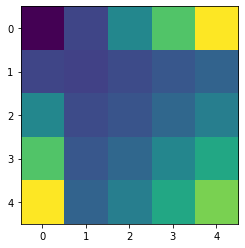

In [5]:
shells = [A1,A2,A3,A4,A5]
Ns = len(shells)

P = np.zeros((Ns,Ns))
for ai in range(Ns):
    for bi in range(Ns):
        P[ai,bi] = 1./(ai+1) + 4./(bi+1) + 5*(ai+bi)/(ai*bi+1) + ai * bi 
P += P.T
P /= np.sqrt(np.sum(P**2))
print('Density matrix:')
print(P)
_ = plt.imshow(P)
plt.show()

In [6]:
# Start easy, Coulomb term, no exchange

grad_n = np.zeros((Ns,3))
grad_e = np.zeros((Ns,3))
dx = 1.e-5

Exc0 = 0.
for ai in range(Ns):
    for bi in range(Ns):
        for ci in range(Ns):
            for di in range(Ns):
                a = shells[ai]
                b = shells[bi]
                c = shells[ci]
                d = shells[di]
                I = ssss_4c2e( a,b,G, c,d,N, H )
                Exc0 += P[ai][bi] * P[ci][di] * I

o = 0                
for A in shells:
    for dd in [0,1,2]:
        ExcP = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        # here and in many other places
                        # we make extra sure we are moving A
                        # in all shells exactly once
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] += dx
                        if b.i == A.i: b.R[dd] += dx
                        if c.i == A.i: c.R[dd] += dx
                        if d.i == A.i: d.R[dd] += dx
                        I = ssss_4c2e( a,b,G, c,d,N, H )
                        ExcP += P[ai][bi] * P[ci][di] * I
                        if a.i == A.i: a.R[dd] -= dx
                        if b.i == A.i: b.R[dd] -= dx
                        if c.i == A.i: c.R[dd] -= dx
                        if d.i == A.i: d.R[dd] -= dx
        ExcM = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] -= dx
                        if b.i == A.i: b.R[dd] -= dx
                        if c.i == A.i: c.R[dd] -= dx
                        if d.i == A.i: d.R[dd] -= dx
                        I = ssss_4c2e( a,b,G, c,d,N, H )
                        ExcM += P[ai][bi] * P[ci][di] * I
                        if a.i == A.i: a.R[dd] += dx
                        if b.i == A.i: b.R[dd] += dx
                        if c.i == A.i: c.R[dd] += dx
                        if d.i == A.i: d.R[dd] += dx
        
        best_val = (ExcP - ExcM) / dx / 2
        uppr_val = (ExcP - Exc0)/dx
        down_val = (Exc0 - ExcM)/dx
        grad_n[o][dd] = best_val
        grad_e[o][dd] = max(abs(best_val-uppr_val),abs(best_val-down_val))
    o += 1
    
print('Numerical Grad:')
print(grad_n)
print('+/-')
print(grad_e)
print()
print('Total grad:', np.sum(grad_n,axis=0))


Numerical Grad:
[[ 1.18493981  1.49247183  2.03496761]
 [-1.5980244  -1.22203033 -1.64254199]
 [ 0.17006965 -1.14516981  0.5599287 ]
 [-0.09036631 -0.00542988 -0.01045426]
 [ 0.33338125  0.88015819 -0.94190007]]
+/-
[[8.98565666e-06 6.36801722e-06 1.06918918e-06]
 [2.18016716e-06 1.58895119e-06 2.94062552e-06]
 [3.21680460e-06 1.61759495e-06 2.21724861e-06]
 [5.74118530e-07 1.16262555e-07 1.12176934e-07]
 [1.31291422e-05 9.72648628e-06 8.81112960e-06]]

Total grad: [ 1.77635906e-10 -1.11022336e-09 -2.66453193e-10]


In [7]:
# Coulomb term, no simmetry, the a+ gradient works

grad = np.zeros((Ns,3))
for ai in range(Ns):
    for bi in range(Ns):
        for ci in range(Ns):
            for di in range(Ns):
                a = shells[ai]
                b = shells[bi]
                c = shells[ci]
                d = shells[di]
                DI = grad_ssss( a,b,G, c,d,N, H )
                
                grad[ai] += 4*P[ai][bi] * P[ci][di] * DI[0:3]
        
print('Analytical Grad:')          
print(grad)
print()
print('Analytical / Numerical:')
print(grad / grad_n)
print()
print('Analytical - Numerical:')
print(grad - grad_n)
print()
print('Total grad:', np.sum(grad,axis=0))

ratio_check = np.any( np.abs(grad/grad_n)-1 > 0.001 )
diff__check = np.any( np.abs(grad-grad_n)   > 0.001 )
failed = diff__check or ratio_check
success = not failed

print()
print()
print('Grad check:', end=' ')
if success:
    print('PASS')
else:
    print('FAIL')
print()

Analytical Grad:
[[ 1.18493981  1.49247183  2.03496761]
 [-1.5980244  -1.22203033 -1.64254199]
 [ 0.17006965 -1.14516981  0.5599287 ]
 [-0.09036631 -0.00542988 -0.01045426]
 [ 0.33338125  0.88015819 -0.94190007]]

Analytical / Numerical:
[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         0.99999996 1.00000004]
 [1.         1.         1.        ]]

Analytical - Numerical:
[[-1.55689905e-10  3.55391938e-10  3.65401043e-11]
 [-4.98694419e-11  2.27999397e-10 -7.22992777e-11]
 [ 1.64566832e-10  2.45833132e-10  6.05695494e-10]
 [-2.66337979e-10  2.38417019e-10 -3.85779601e-10]
 [ 1.29693867e-10  4.25807167e-11  8.22977242e-11]]

Total grad: [-7.21644966e-16 -1.11022302e-15  1.22124533e-15]


Grad check: PASS



In [8]:
# gradient of the exchange 

grad_n = np.zeros((Ns,3))
grad_e = np.zeros((Ns,3))
dx = 1.e-5

Exc0 = 0.
for ai in range(Ns):
    for bi in range(Ns):
        for ci in range(Ns):
            for di in range(Ns):
                a = shells[ai]
                b = shells[bi]
                c = shells[ci]
                d = shells[di]
                I = exc_1324_ssss( a,b,G, c,d,N, H )
                Exc0 += P[ai][bi] * P[ci][di] * I

o = 0                
for A in shells:
    for dd in [0,1,2]:
        ExcP = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] += dx
                        if b.i == A.i: b.R[dd] += dx
                        if c.i == A.i: c.R[dd] += dx
                        if d.i == A.i: d.R[dd] += dx
                        I = exc_1324_ssss( a,b,G, c,d,N, H )
                        ExcP += P[ai][bi] * P[ci][di] * I
                        if a.i == A.i: a.R[dd] -= dx
                        if b.i == A.i: b.R[dd] -= dx
                        if c.i == A.i: c.R[dd] -= dx
                        if d.i == A.i: d.R[dd] -= dx
        ExcM = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] -= dx
                        if b.i == A.i: b.R[dd] -= dx
                        if c.i == A.i: c.R[dd] -= dx
                        if d.i == A.i: d.R[dd] -= dx
                        I = exc_1324_ssss( a,b,G, c,d,N, H )
                        ExcM += P[ai][bi] * P[ci][di] * I
                        if a.i == A.i: a.R[dd] += dx
                        if b.i == A.i: b.R[dd] += dx
                        if c.i == A.i: c.R[dd] += dx
                        if d.i == A.i: d.R[dd] += dx
        
        best_val = (ExcP - ExcM) / dx / 2
        uppr_val = (ExcP - Exc0)/dx
        down_val = (Exc0 - ExcM)/dx
        grad_n[o][dd] = best_val
        grad_e[o][dd] = max(abs(best_val-uppr_val),abs(best_val-down_val))
    o += 1
    
print('Numerical Grad:')
print(grad_n)
print('+/-')
print(grad_e)
print()
print('Total grad:', np.sum(grad_n,axis=0))


Numerical Grad:
[[ 1.0811572   1.36596904  1.79064614]
 [-1.65248681 -1.30545191 -1.68204072]
 [ 0.16470465 -1.13373289  0.55420589]
 [-0.09441034 -0.0069683  -0.01218455]
 [ 0.50103529  1.08018406 -0.65062676]]
+/-
[[7.59903251e-06 5.28030952e-06 1.26250121e-06]
 [1.93036698e-06 1.23074884e-06 2.79469781e-06]
 [3.17532667e-06 1.61333169e-06 2.19491092e-06]
 [5.92237370e-07 1.17506005e-07 1.13065113e-07]
 [1.15936594e-05 7.89430743e-06 8.78590534e-06]]

Total grad: [ 3.10862669e-10 -3.10862669e-10  3.55271368e-10]


In [9]:
# cp2k-style-simmetry exchange gradient

grad = np.zeros((Ns,3))
for ai in range(Ns):
    for bi in range(Ns):
        for ci in range(Ns):
            for di in range(Ns):
                
                if di < ci:
                    continue
                if bi < ai:
                    continue
                if ai == bi and ai == ci and ai == di:
                    continue
                if not (ci + di <= ai + bi):
                    continue
                if ai + bi == ci + di and ci < ai:
                    continue

                symm_fac = 0.5
                if (ai == bi):
                    symm_fac = symm_fac*2.0
                if (ci == di):
                    symm_fac = symm_fac*2.0
                if (ai == ci and bi == di and ai != bi and ci != di):
                    symm_fac = symm_fac*2.0
                if (ai == ci and ai == bi and ci == di):
                    symm_fac = symm_fac*2.0

                symm_fac = 1./symm_fac
                    
                a = shells[ai]
                b = shells[bi]
                c = shells[ci]
                d = shells[di]
                # note, cp2k exchanges the density instead of the integrals
                DI = grad_ssss( a,b,G, c,d,N, H )                
    
                grad[ai] += 2*symm_fac*P[ai][ci] * P[bi][di] * DI[0:3]
                grad[ai] += 2*symm_fac*P[ai][di] * P[bi][ci] * DI[0:3]
        
                grad[bi] += 2*symm_fac*P[ai][ci] * P[bi][di] * DI[3:6]
                grad[bi] += 2*symm_fac*P[ai][di] * P[bi][ci] * DI[3:6]
                
                grad[ci] += 2*symm_fac*P[ai][ci] * P[bi][di] * DI[6:9]
                grad[ci] += 2*symm_fac*P[ai][di] * P[bi][ci] * DI[6:9]
                
                grad[di] += 2*symm_fac*P[ai][ci] * P[bi][di] * DI[9:]
                grad[di] += 2*symm_fac*P[ai][di] * P[bi][ci] * DI[9:]
                
#                print( ai+1 , bi+1, ci+1, di+1, )
        

print('Analytical Grad:')          
print(grad)
print()
print('Analytical / Numerical:')
print(grad / grad_n)
print()
print('Analytical - Numerical:')
print(grad - grad_n)
print()
print('Total grad:', np.sum(grad,axis=0))

ratio_check = np.any( np.abs(grad/grad_n)-1 > 0.001 )
diff__check = np.any( np.abs(grad-grad_n)   > 0.001 )
failed = diff__check or ratio_check
success = not failed

print()
print()
print('Grad check:', end=' ')
if success:
    print('PASS')
else:
    print('FAIL')
print()

Analytical Grad:
[[ 1.0811572   1.36596904  1.79064614]
 [-1.65248681 -1.30545191 -1.68204072]
 [ 0.16470465 -1.13373289  0.55420589]
 [-0.09441034 -0.0069683  -0.01218455]
 [ 0.50103529  1.08018406 -0.65062676]]

Analytical / Numerical:
[[1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.        ]
 [1.         1.         1.00000002]
 [1.         1.         1.        ]]

Analytical - Numerical:
[[-1.21713750e-10 -2.69262390e-11 -2.33999486e-11]
 [-9.16926535e-11  1.43488332e-10 -1.06540998e-10]
 [ 1.58352553e-10  2.10719442e-10 -3.04176129e-10]
 [-2.43025045e-12  2.02964546e-11 -2.22858829e-10]
 [-2.53379762e-10 -3.67170738e-11  3.01701553e-10]]

Total grad: [-1.22124533e-15 -1.77635684e-15 -2.99760217e-15]


Grad check: PASS



# End of notebook, scattered notes from here on

In [10]:
shell_list = []
for s1 in shells:
    for s2 in shells:
        for s3 in shells:
            for s4 in shells:
                shell_list.append([s1,s2,s3,s4])

overall_success = True
for shell4 in shell_list:
    d_n = [0.,0.,0.]
    e_n = [0.,0.,0.]
    
    oS1 = deepcopy(shell4[0])
    oS2 = deepcopy(shell4[1])
    oS3 = deepcopy(shell4[2])
    oS4 = deepcopy(shell4[3])
    
    og  = ssss_4c2e( oS1,oS2,G, oS3,oS4,N, H  )
    d_a = grad_ssss( oS1,oS2,G, oS3,oS4,N, H  )
            
    dx = 1.e-6 
    for d in [0,1,2]:

        tS1 = deepcopy(shell4[0])
        tS2 = deepcopy(shell4[1])
        tS3 = deepcopy(shell4[2])
        tS4 = deepcopy(shell4[3])
        
        tS1.R[d] += dx
        if tS1.i == tS2.i : tS2.R[d] += dx
        if tS1.i == tS3.i : tS3.R[d] += dx
        if tS1.i == tS4.i : tS4.R[d] += dx
        pr = ssss_4c2e( tS1,tS2,G, tS3,tS4,N, H )
        
        tS1.R[d] -= 2*dx
        if tS1.i == tS2.i : tS2.R[d] -= 2*dx
        if tS1.i == tS3.i : tS3.R[d] -= 2*dx
        if tS1.i == tS4.i : tS4.R[d] -= 2*dx
        mr = ssss_4c2e( tS1,tS2,G, tS3,tS4,N, H )

        tS1.R[d] += dx
        if tS1.i == tS2.i : tS2.R[d] += dx
        if tS1.i == tS3.i : tS3.R[d] += dx
        if tS1.i == tS4.i : tS4.R[d] += dx

        dp = (pr-og)/dx
        dm = (og-mr)/dx
        best_val = (pr-mr)/dx/2
        err = max(abs(best_val-dp),abs(best_val-dm))
        d_n[d] = best_val
        e_n[d] = err

    ratio_check = False
    d_n2 = np.sum([x**2 for x in d_n]) 
    d_a2 = np.sum([x**2 for x in d_a])
    if tS1.i == tS2.i : d_a[0:3] += d_a[3:6] 
    if tS1.i == tS3.i : d_a[0:3] += d_a[6:9] 
    if tS1.i == tS4.i : d_a[0:3] += d_a[9:12] 
    print(oS1.i , oS2.i , oS3.i , oS4.i, d_n, d_a[0:3] )
    
    if d_n2 > 1.e-6 or d_a2 > 1.e-6:
        ratio_check = np.any( np.abs(d_n/d_a[0:3]-1) > 1.e-3 )
    diff__check = np.any( np.abs(d_n-d_a[0:3]) > 1.e-3 )
    failed = diff__check or ratio_check
    success = not failed
    
    if not success:
        print(oS1.i , oS2.i , oS3.i , oS4.i, d_n, d_a )
        overall_success = False
        
print('All shells check:', end=' ')
if overall_success:
    print('PASS')
else:
    print('FAIL')

1 1 1 1 [0.0, 0.0, 0.0] [0. 0. 0.]
1 1 1 2 [0.2631765310123768, 0.28710167021550603, 0.3110268093631241] [0.26317653 0.28710167 0.31102681]
1 1 1 3 [0.04599118594295071, 0.2420012404219518, 0.010950282361421593] [0.04599119 0.24200124 0.01095028]
1 1 1 4 [3.941741479462348e-06, 1.2170353873102073e-06, 1.2079530342345652e-06] [3.94174148e-06 1.21703539e-06 1.20795303e-06]
1 1 1 5 [0.3201900100058275, 0.3201900100058275, 0.6874667861644923] [0.32019001 0.32019001 0.68746679]
1 1 2 1 [0.2631765310401324, 0.2871016702432616, 0.3110268093908797] [0.26317653 0.28710167 0.31102681]
1 1 2 2 [0.43902602298029336, 0.4789374797864454, 0.5188489364815752] [0.43902602 0.47893748 0.51884894]
1 1 2 3 [0.08764720213494392, 0.14539926540546588, 0.09231897657446808] [0.0876472  0.14539927 0.09231898]
1 1 2 4 [0.0008857547976331981, 0.0003426164879149346, 0.0003488147030331762] [0.00088575 0.00034262 0.00034881]
1 1 2 5 [0.1529763083985003, 0.16175640960014448, 0.23522511632956267] [0.15297631 0.16175641

1 5 5 3 [0.07147167606358362, 0.08471912756047306, 0.14752018374919462] [0.07147168 0.08471913 0.14752018]
1 5 5 4 [8.036408444297267e-07, 6.376581224526537e-07, 1.2834944861832973e-06] [8.03640845e-07 6.37658122e-07 1.28349449e-06]
1 5 5 5 [0.3386253271675521, 0.3386253271675521, 0.7270484964627677] [0.33862533 0.33862533 0.7270485 ]
2 1 1 1 [-0.2631765310401324, -0.28710167021550603, -0.31102680944639083] [-0.26317653 -0.28710167 -0.31102681]
2 1 1 2 [-0.17333861138113527, -0.18909666699845618, -0.2048547225880215] [-0.17333861 -0.18909667 -0.20485472]
2 1 1 3 [-0.062149668335342856, -0.06299509545948379, -0.07453667635881622] [-0.06214967 -0.0629951  -0.07453668]
2 1 1 4 [-2.150926078978861e-07, -2.896632978056733e-07, -3.157738084357318e-07] [-2.15092608e-07 -2.89663298e-07 -3.15773808e-07]
2 1 1 5 [-0.19622394281659794, -0.2150082305946155, -0.22185940955210537] [-0.19622394 -0.21500823 -0.22185941]
2 1 2 1 [-0.17333861137419637, -0.18909666699845618, -0.20485472258108262] [-0.173

2 5 1 1 [-0.4899162174276661, -0.5504509376086375, -0.40914264415325974] [-0.48991622 -0.55045094 -0.40914264]
2 5 1 2 [-0.4209432490076548, -0.46714664261870986, -0.413218591233111] [-0.42094325 -0.46714664 -0.41321859]
2 5 1 3 [-0.12406979169043986, -0.13046598967836331, -0.10475588799185864] [-0.12406979 -0.13046599 -0.10475589]
2 5 1 4 [-4.966015278053832e-07, -7.254124669647248e-07, -5.005968365808544e-07] [-4.96601528e-07 -7.25412467e-07 -5.00596836e-07]
2 5 1 5 [-0.40945625756627635, -0.46134346673443183, -0.3282065977883164] [-0.40945626 -0.46134347 -0.3282066 ]
2 5 2 1 [-0.4209432490076548, -0.46714664261870986, -0.413218591233111] [-0.42094325 -0.46714664 -0.41321859]
2 5 2 2 [-2.5407660881882066, -2.875077415920302, -1.9055745668072888] [-2.54076609 -2.87507742 -1.90557457]
2 5 2 3 [-0.6307191856569361, -0.31724781435205074, -0.6267690633166012] [-0.63071919 -0.31724781 -0.62676906]
2 5 2 4 [0.008396340024294235, -0.0030851676127013894, -0.0022689358547371696] [ 0.00839634 -

3 5 4 1 [9.40417932642393e-09, -2.2083647095328308e-07, 7.60881318833294e-08] [ 9.40417934e-09 -2.20836471e-07  7.60881319e-08]
3 5 4 2 [1.674194615407243e-05, -0.001097087001214643, 0.00038921925665097445] [ 1.67419463e-05 -1.09708700e-03  3.89219256e-04]
3 5 4 3 [0.0011982453444726003, -0.000854997979588077, 0.0005804000887755026] [ 0.00119825 -0.000855    0.0005804 ]
3 5 4 4 [0.00013832029618909836, -0.05675386026762763, 0.019727871669594776] [ 0.00013832 -0.05675386  0.01972787]
3 5 4 5 [2.795996302467504e-08, -6.021628185921746e-07, 2.1558648289857912e-07] [ 2.79599630e-08 -6.02162819e-07  2.15586483e-07]
3 5 5 1 [-0.009238403028688502, -0.15964600172391208, 0.047534160704798545] [-0.0092384  -0.159646    0.04753416]
3 5 5 2 [-0.002567834070377195, -0.19792095191928372, 0.07369228069431522] [-0.00256783 -0.19792095  0.07369228]
3 5 5 3 [-0.005306132574989242, -0.12403084873741088, 0.0417857939777333] [-0.00530613 -0.12403085  0.04178579]
3 5 5 4 [2.795996302467504e-08, -6.02162818

5 1 5 4 [7.480569739164636e-06, 1.4475030559987754e-06, -3.2954761254664743e-09] [ 7.48056974e-06  1.44750306e-06 -3.29547553e-09]
5 1 5 5 [-0.3386253271675521, -0.3386253271675521, -0.7270484964072566] [-0.33862533 -0.33862533 -0.7270485 ]
5 2 1 1 [0.33693990897365467, 0.388694528008493, 0.17391752782369707] [0.33693991 0.38869453 0.17391753]
5 2 1 2 [0.1758657724448831, 0.20154050192622286, 0.10498894256749658] [0.17586577 0.2015405  0.10498894]
5 2 1 3 [0.09164738706823883, 0.12209802166540662, 0.04705624186140955] [0.09164739 0.12209802 0.04705624]
5 2 1 4 [9.239466646283244e-07, 7.548457480864256e-07, 4.650968792801818e-07] [9.23946665e-07 7.54845748e-07 4.65096879e-07]
5 2 1 5 [0.1636789826453544, 0.21112105408338522, -0.15229476496569916] [ 0.16367898  0.21112105 -0.15229476]
5 2 2 1 [0.1758657724448831, 0.20154050192622286, 0.10498894256749658] [0.17586577 0.2015405  0.10498894]
5 2 2 2 [2.5407660877441174, 2.8750774154762126, 1.9055745663631996] [2.54076609 2.87507742 1.905574

In [11]:
grad_n = np.zeros((Ns,3))
grad_e = np.zeros((Ns,3))
dx = 1.e-5

Exc0 = 0.
for ai in range(Ns):
    for bi in range(Ns):
        for ci in range(Ns):
            for di in range(Ns):
                a = shells[ai]
                b = shells[bi]
                c = shells[ci]
                d = shells[di]
                I = exc_1324_ssss( a,b,G, c,d,N, H )
                Exc0 += P[ai][bi] * P[ci][di] * I

o = 0                
for A in shells:
    for dd in [0,1,2]:
        ExcP = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] += dx
                        if b.i == A.i: b.R[dd] += dx
                        if c.i == A.i: c.R[dd] += dx
                        if d.i == A.i: d.R[dd] += dx
                        I = exc_1324_ssss( a,b,G, c,d,N, H )
                        ExcP += P[ai][bi] * P[ci][di] * I
                        if a.i == A.i: a.R[dd] -= dx
                        if b.i == A.i: b.R[dd] -= dx
                        if c.i == A.i: c.R[dd] -= dx
                        if d.i == A.i: d.R[dd] -= dx
        ExcM = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] -= dx
                        if b.i == A.i: b.R[dd] -= dx
                        if c.i == A.i: c.R[dd] -= dx
                        if d.i == A.i: d.R[dd] -= dx
                        I = exc_1324_ssss( a,b,G, c,d,N, H )
                        ExcM += P[ai][bi] * P[ci][di] * I
                        if a.i == A.i: a.R[dd] += dx
                        if b.i == A.i: b.R[dd] += dx
                        if c.i == A.i: c.R[dd] += dx
                        if d.i == A.i: d.R[dd] += dx
        
        best_val = (ExcP - ExcM) / dx / 2
        uppr_val = (ExcP - Exc0)/dx
        down_val = (Exc0 - ExcM)/dx
        grad_n[o][dd] = best_val
        grad_e[o][dd] = max(abs(best_val-uppr_val),abs(best_val-down_val))
    o += 1
    
print('Numerical Grad 2 :')
print(grad_n)
print('+/-')
print(grad_e)
print()
print('Total grad:', np.sum(grad_n,axis=0))

Numerical Grad 2 :
[[ 1.0811572   1.36596904  1.79064614]
 [-1.65248681 -1.30545191 -1.68204072]
 [ 0.16470465 -1.13373289  0.55420589]
 [-0.09441034 -0.0069683  -0.01218455]
 [ 0.50103529  1.08018406 -0.65062676]]
+/-
[[7.59903251e-06 5.28030952e-06 1.26250121e-06]
 [1.93036698e-06 1.23074884e-06 2.79469781e-06]
 [3.17532667e-06 1.61333169e-06 2.19491092e-06]
 [5.92237370e-07 1.17506005e-07 1.13065113e-07]
 [1.15936594e-05 7.89430743e-06 8.78590534e-06]]

Total grad: [ 3.10862669e-10 -3.10862669e-10  3.55271368e-10]


In [12]:
grad = np.zeros((Ns,3))
for ai in range(Ns):
    for bi in range(Ns):
        for ci in range(Ns):
            for di in range(Ns):
                a = shells[ai]
                b = shells[bi]
                c = shells[ci]
                d = shells[di]
                n = count_a_sum( a,b,G, c,d,N, H )
                DI = exc_1324_grad_ssss( a,b,G, c,d,N, H )
                grad[ai] += n * ( P[ai][bi] * P[ci][di] ) * DI[0:3]
                
print('Analytical Grad:')          
print(grad)
print()
print('Analytical / Numerical:')
print(grad / grad_n)
print()
print('Analytical - Numerical:')
print(grad - grad_n)
print()
print('Total grad:', np.sum(grad,axis=0))

ratio_check = np.any( np.abs(grad/grad_n)-1 > 0.001 )
diff__check = np.any( np.abs(grad-grad_n)   > 0.001 )
failed = diff__check or ratio_check
success = not failed

print()
print()
print('Grad check:', end=' ')
if success:
    print('PASS')
else:
    print('FAIL')
print()

Analytical Grad:
[[ 0.3732631   0.47012085  0.62754505]
 [-0.70694408 -0.53404807 -0.72508069]
 [ 0.05693015 -0.37568605  0.18606229]
 [-0.04155401 -0.00355387 -0.00551759]
 [ 0.1634652   0.39874745 -0.34719363]]

Analytical / Numerical:
[[0.34524406 0.34416655 0.35045732]
 [0.42780619 0.40909057 0.43107202]
 [0.34564991 0.33137087 0.33572775]
 [0.44014254 0.51000564 0.45283477]
 [0.32625486 0.36914769 0.53362949]]

Analytical - Numerical:
[[-0.7078941  -0.89584819 -1.16310109]
 [ 0.94554273  0.77140384  0.95696002]
 [-0.1077745   0.75804684 -0.36814359]
 [ 0.05285633  0.00341443  0.00666696]
 [-0.33757009 -0.68143661  0.30343313]]

Total grad: [-0.15483964 -0.04441969 -0.26418456]


Grad check: FAIL



In [13]:
shell_list = []
for s1 in shells:
    for s2 in shells:
        for s3 in shells:
            for s4 in shells:
                shell_list.append([s1,s2,s3,s4])
shell_list = [
    (A1,A2,A1,A1),
    (A1,A1,A1,A2)
]

overall_success = True
for shell4 in shell_list:
    d_n = [0.,0.,0.]
    e_n = [0.,0.,0.]
    
    oS1 = deepcopy(shell4[0])
    oS2 = deepcopy(shell4[1])
    oS3 = deepcopy(shell4[2])
    oS4 = deepcopy(shell4[3])
    
    og = ssss_4c2e( oS1,oS2,G, oS3,oS4,N, H  )
    d_a = grad_ssss( oS1,oS2,G, oS3,oS4,N, H  )
            
    dx = 1.e-6 
    for d in [0,1,2]:

        tS1 = deepcopy(shell4[0])
        tS2 = deepcopy(shell4[1])
        tS3 = deepcopy(shell4[2])
        tS4 = deepcopy(shell4[3])
        
        tS1.R[d] += dx
        pr = ssss_4c2e( tS1,tS2,G, tS3,tS4,N, H )
        
        tS1.R[d] -= 2*dx
        mr = ssss_4c2e( tS1,tS2,G, tS3,tS4,N, H )

        tS1.R[d] += dx

        dp = (pr-og)/dx
        dm = (og-mr)/dx
        best_val = (pr-mr)/dx/2
        err = max(abs(best_val-dp),abs(best_val-dm))
        d_n[d] = best_val
        e_n[d] = err
    
    print(oS1.i , oS2.i , oS3.i , oS4.i, d_n, d_a )


1 2 1 1 [0.20336303216406115, 0.22185058062840213, 0.24033812892620965] [ 0.20336303  0.22185058  0.24033813 -0.26317653 -0.28710167 -0.31102681
  0.02990675  0.03262554  0.03534434  0.02990675  0.03262554  0.03534434]
1 1 1 2 [0.029906749410280042, 0.03262554482130753, 0.03534434020457944] [ 0.02990675  0.03262554  0.03534434  0.02990675  0.03262554  0.03534434
  0.20336303  0.22185058  0.24033813 -0.26317653 -0.28710167 -0.31102681]


In [14]:

grad_n = np.zeros((Ns,3))
grad_e = np.zeros((Ns,3))
dx = 1.e-5

Exc0 = 0.
for ai in range(Ns):
    for bi in range(Ns):
        for ci in range(Ns):
            for di in range(Ns):
                a = shells[ai]
                b = shells[bi]
                c = shells[ci]
                d = shells[di]
                I = exc_1324_ssss( a,b,G, c,d,N, H )
                Exc0 += P[ai][bi] * P[ci][di] * I

o = 0                
for A in shells:
    for dd in [0,1,2]:
        ExcP = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] += dx
                        I = exc_1324_ssss( a,b,G, c,d,N, H )
                        ExcP += P[ai][bi] * P[ci][di] * I
                        if a.i == A.i: a.R[dd] -= dx
        ExcM = 0.
        for ai in range(Ns):
            for bi in range(Ns):
                for ci in range(Ns):
                    for di in range(Ns):
                        a = deepcopy(shells[ai])
                        b = deepcopy(shells[bi])
                        c = deepcopy(shells[ci])
                        d = deepcopy(shells[di])
                        if a.i == A.i: a.R[dd] -= dx
                        I = exc_1324_ssss( a,b,G, c,d,N, H )
                        ExcM += P[ai][bi] * P[ci][di] * I
                        if a.i == A.i: a.R[dd] += dx
        
        best_val = (ExcP - ExcM) / dx / 2
        uppr_val = (ExcP - Exc0)/dx
        down_val = (Exc0 - ExcM)/dx
        grad_n[o][dd] = best_val
        grad_e[o][dd] = max(abs(best_val-uppr_val),abs(best_val-down_val))
    o += 1
    
print('Numerical Grad:')
print(grad_n)
print('+/-')
print(grad_e)
print()
print('Total grad:', np.sum(grad_n,axis=0))

Numerical Grad:
[[ 0.2702893   0.34149226  0.44766154]
 [-0.4131217  -0.32636298 -0.42051018]
 [ 0.04117616 -0.28343322  0.13855147]
 [-0.02360259 -0.00174207 -0.00304614]
 [ 0.12525882  0.27004602 -0.16265669]]
+/-
[[3.66378039e-06 3.18154392e-06 2.42685871e-06]
 [4.23256985e-06 4.02180511e-06 4.41238157e-06]
 [1.04973807e-06 6.18616269e-08 8.53761506e-07]
 [1.13224985e-06 1.27595712e-06 1.27462485e-06]
 [8.57340865e-06 7.82156562e-06 8.10249645e-06]]

Total grad: [-2.66453470e-10 -1.77635739e-10  2.22044605e-10]
